# Embeddings for Recommendations

Here I use a move rating data set from Kaggle.
In this notebook I will derive embeddings for users and movies
and these will be the ingredients of a matrix factorization
of the full rating matrix.

We will train a simple Neural Net using Pytorch.

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import torch.cuda

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

## According to the cuda documentation this can be helpful in debugging
alhough I have not used it yet.

In [3]:
!export CUDA_LAUNCH_BLOCKING=1

### Note: In case I decide to use the GPU card

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device in use:", device)

Device in use: cuda


In [5]:
## Read in the data and show shape and head

In [6]:
origdf = pd.read_csv("ratings.csv")
print(origdf.shape)
origdf.head(2)

(26024289, 4)


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435


In [7]:
print(f"max userId {origdf.userId.max()} num users {origdf.userId.nunique()}")
print(f"max movieId {origdf.movieId.max()} num movies {origdf.movieId.nunique()}")

max userId 270896 num users 270896
max movieId 176275 num movies 45115


# Subsampling
The original dataset was too large for my Cuda memory
so I will subsample to a much saller set.

In [8]:
subsample = True
df = origdf.copy()
if subsample:
    max_user =  10000
    max_movie = 5000
    df = df.loc[df.movieId < max_movie]
    df = df.loc[df.userId < max_user]
    print(f"max userId {df.userId.max()} num users {df.userId.nunique()}")
    print(f"max movieId {df.movieId.max()} num movies {df.movieId.nunique()}")    
    print(df.shape)    

max userId 9999 num users 9930
max movieId 4999 num movies 4783
(676352, 4)


## Partition the dataset
into train and validation.
We can use val to tune the hyper parameters.

We could use the sklearn function but I find this just as easy.

In [9]:
def partition(df, pct=0.1):
    size = int(np.floor(df.shape[0])*0.1)
    idx = list(np.random.choice(df.index, size, replace=False))
    subset = df.filter(items=idx, axis=0)
    rest = df.drop(index = idx)
    return subset, rest

valdf, traindf = partition(df, 0.2)

print(f" valid: {valdf.shape}, train {traindf.shape}")
traindf.reset_index(inplace=True)
valdf.reset_index(inplace=True)

 valid: (67635, 4), train (608717, 4)


## the Model
The model is fairly simple: 2 embedding layers, 
    one each for users and movies.
    
At the end of "froward" we simply do the dot product of users and movie embeddings.

In [10]:
class MF(nn.Module):
    def __init__(self, n_users, n_movies, emb_size=100):
        super(MF, self).__init__()
        self.n_users = n_users
        self.n_movies = n_movies
        self.user_emb = nn.Embedding(n_users, emb_size)
        self.movie_emb = nn.Embedding(n_movies, emb_size)
        
        # initializing our matrices with a positive number generally will yield better results
        self.user_emb.weight.data.uniform_(0, 0.5)
        self.movie_emb.weight.data.uniform_(0, 0.5)
    
    def forward(self, users, movies):
        m = self.movie_emb(movies)
        u = self.user_emb(users)
        return (u * m).sum(1)  # taking the dot product

## Dataset and dataloader
I want to use mini-batch training so we need a dataset
and a dataloader.

I adapted some code for converting a pandas dataframe into a dataloader

In [11]:
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        print(f" len {dataframe.shape[0]}")

    def __getitem__(self, index):
        userid = self.dataframe.userId[index]
        movieid = self.dataframe.movieId[index]
        rating = np.float32(self.dataframe.rating[index])
        return userid, movieid, rating

    def __len__(self):
        length = self.dataframe.shape[0]
        return length
                              
traindata = CustomDataset(dataframe=traindf)
train_dataloader = DataLoader(traindata, batch_size=64)

valdata = CustomDataset(dataframe=valdf)
val_dataloader = DataLoader(valdata, batch_size=64) 


 len 608717
 len 67635


In [12]:
def instantiate_model(n_users, n_movies, emb_size=64):
    print(f" emb size {emb_size}")
    n_users = df.userId.max()+1
    n_movies = df.movieId.max()+1
    model = MF(n_users=n_users, n_movies=n_movies, emb_size=emb_size)
    return model

# for now I am not experimenting with weight decay.  maybe later.
def train_model(model, epochs=2, lr=0.01, wd=0.0, use_cuda=False, print_freq=500):
    print(f"epochs: {epochs}  lr: {lr}")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    if use_cuda:
        if torch.cuda.is_available():
            model = model.to(device)
            print(f"\tusing cuda = {next(model.parameters()).is_cuda}")
    start_dt = datetime.datetime.now()            
    #
    # train loop
    #
    model.train()
    train_rmse = []    
    val_rmse = []      
    for ei in range(epochs):
        epoch_mse = 0.0
        for tbi, data in enumerate(train_dataloader):
            users, movies, ratings = data
            if use_cuda:
                users = users.cuda()
                movies = movies.cuda()
                ratings = ratings.cuda()
            else:
                users = users
                movies = movies
                ratings = ratings                    
            y_hat = model(users, movies)
            loss = F.mse_loss(y_hat, ratings)
            epoch_mse += loss.item() 
            optimizer.zero_grad()  # reset gradient
            loss.backward()
            optimizer.step() 
        mse = np.round(epoch_mse/len(train_dataloader))
        rmse = np.sqrt(mse)
        train_rmse.append(rmse)

    
        #    
        # eval loop
        #
        model.eval()        
        epoch_mse = 0.0        
        for tbi, data in enumerate(val_dataloader):
            users, movies, ratings = data
            if use_cuda:
                users = users.cuda()
                movies = movies.cuda()
                ratings = ratings.cuda()
            else:
                users = users
                movies = movies
                ratings = ratings 
            y_hat = model(users, movies)
            loss = F.mse_loss(y_hat, ratings)
            epoch_mse += loss.item()
        mse = np.round(epoch_mse/len(val_dataloader))
        rmse = np.sqrt(mse)
        val_rmse.append(rmse)
        
    print(f"\tdone with train epochs")
    
    df = pd.DataFrame()
    df["train"] = train_rmse
    df["val"] = val_rmse
    df["epoch"] = range(len(train_rmse))
    return df


In [13]:
n_users = df.userId.max()
n_movies = df.movieId.max()
dflist = []
models = {}
for epochs in [10]:
    for emb_size in [ 64, 128, 256]:
        for lr in [0.005, .0025, 0.001]:
            model = instantiate_model(n_users=n_users, n_movies=n_movies, emb_size=emb_size)
            tdf = train_model(model=model, epochs=epochs, lr=lr, wd=0.0, use_cuda=True, print_freq=5000)
            tdf["emb_size"] = emb_size
            tdf["lr"] = lr
            dflist.append(tdf)
            models[emb_size] = model
resdf = pd.concat(dflist)

 emb size 64
epochs: 10  lr: 0.005
	using cuda = True
	done with train epochs
 emb size 64
epochs: 10  lr: 0.0025
	using cuda = True
	done with train epochs
 emb size 64
epochs: 10  lr: 0.001
	using cuda = True
	done with train epochs
 emb size 128
epochs: 10  lr: 0.005
	using cuda = True
	done with train epochs
 emb size 128
epochs: 10  lr: 0.0025
	using cuda = True
	done with train epochs
 emb size 128
epochs: 10  lr: 0.001
	using cuda = True
	done with train epochs
 emb size 256
epochs: 10  lr: 0.005
	using cuda = True
	done with train epochs
 emb size 256
epochs: 10  lr: 0.0025
	using cuda = True
	done with train epochs
 emb size 256
epochs: 10  lr: 0.001
	using cuda = True
	done with train epochs


## Plotting the errors
I'll use Plotnine, an implmentantion of ggplot, to plot   
the errors for each learning rate and embedding size  
  for both train and validation sets.

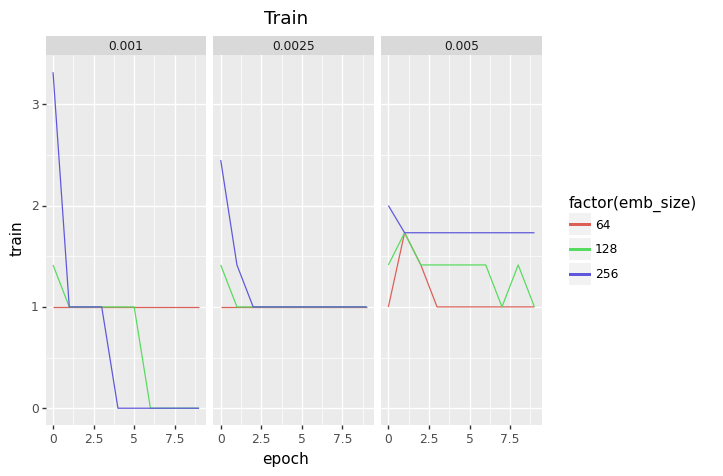

<ggplot: (8763585425144)>

In [14]:
import plotnine
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap, geom_line, labels


trainres = resdf.loc
(ggplot(resdf, aes('epoch', 'train',  color='factor(emb_size)'))
 + geom_line()
 + labels.ggtitle("Train")
 + facet_wrap('~lr'))

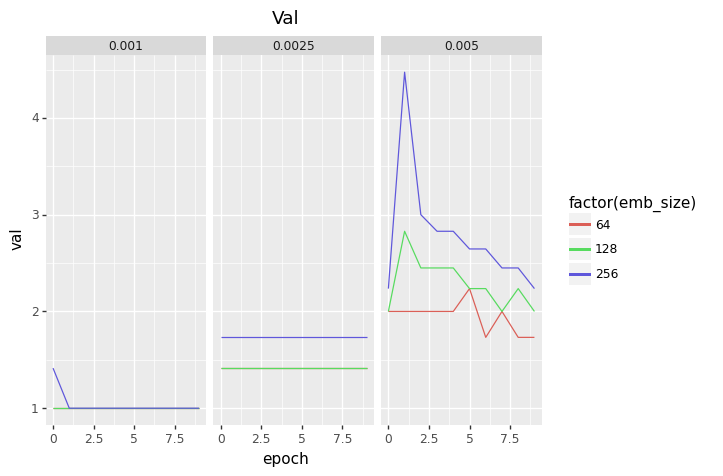

<ggplot: (8763343067626)>

In [15]:
(ggplot(resdf, aes('epoch', 'val',  color='factor(emb_size)'))
 + geom_line() 
 + labels.ggtitle("Val")
 + facet_wrap('~lr'))

# Summary of training
* the smallest learning rate seemed to perform best
* the larger embedding sizes probably overfit given 
     with the larger learning rates
      although they all seemed fine for the smallest learning rate
         for the validation set.

So to go forward I would use
* learning rate = 0.001
* embedding size = 64 or 128


Note that this is loosly based on some code from   
https://betterprogramming.pub/building-a-recommendation-engine-with-pytorch-d64be4856fe7